# 第9回: RNN: Exercise1
## Echo State Networksで神経活動を学習する
### 概要
本演習ではpythonを用いてEcho State Networksを実装します。

学習データセットとして、運動イメージの脳波データを用い、与えられた脳波から４つの運動イメージをデコードします。

まず、講師が概要を説明しますので、全体を掴んだところで演習に取り組んでください。

### 目標
- numpyでESNを実装する
- 神経活動を記録したデータ・セットを学習する
    - EEGから運動イメージを予測する

### 使用するデータセット
#### [Four class motor imagery](http://bnci-horizon-2020.eu/database/data-sets)

- [About this dataset](http://www.bbci.de/competition/iv/desc_1.html)
- Moter Imaginary Tasks(運動イメージタスク)
- 9人の被験者 (今回使用するのは一人)
- 以下の４つの運動イメージについてEEG(electroencephalogram: 脳波記録)を測定
    - [Class1] 右手
    - [Class2] 左手
    - [Class3] 両足
    - [Class4] 舌
- 実験は2session、それぞれ別日に行われた
- 一つのセッションは6回のテストから構成される
- 一つのテストは48試行から構成される
    - 12試行 * 4クラス
- 計: 6テスト * 48試行 = 288試行/人
- 各セッションのはじめに、EEG(脳波)に対するEOG(眼球運動)の影響を測定するため、5分間の計測を実施(Fig.1)
    - (1). 二分間fixation crossを凝視(眼球運動を固定)
    - (2). 一分間目をとじる
    - (3). 一分間目をあける(眼球運動を含む)
![mit](images/mit.png)
- 試行の手続き(Fig.2)
    - (1). fixation cross + a short acoustic warning tone
    - (2). 手がかり(クラスを指し示した矢印の表示)
    - (3). 運動イメージの生成
    - (4). 休憩

![timing](images/timing.png)

![elec](images/elec.png)

In [158]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import scipy.linalg
from scipy.io import loadmat

### データセットの確認

学習データと教師データを読み込んでみましょう。
25channelを収録、内はじめの22セットがEEG、残りの3セットがEOGとなります。

In [160]:
data_x = np.load('./data/ESN/eog1T.npy')  # train
data_y = np.load('./data/ESN/eog1Tt.npy')  # teacher

なお読み込んだデータセットは、`np.ndarray`オブジェクトとして格納されます。
このデータはEOGのセッションを含んでおり、実際の運動イメージタスクは4053サンプル目から始まります。

In [161]:
data_x.shape

(29683, 25)

今回はEOGのセッションは使わないので、運動イメージタスクが開始された直後からを学習データとします。

In [176]:
START = 4053
END = 29683
data = data_x[START:]
teacher = data_y[START:]

実際にデータを見てみましょう。

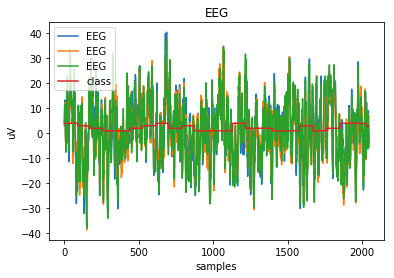

In [163]:
x = data_x[START:6100, :3]
y = data_y[START:6100]
plt.plot(x, label='EEG')
plt.plot(y, label='class')
plt.title('EEG')
plt.xlabel('samples')
plt.ylabel('uV')
plt.legend()
plt.show()

## ESNの実装
では、ESNの実装を始めましょう。今回は、任意の入力(25チャンネル)から、運動イメージのクラス(1チャンネル)を予測し出力します。

In [175]:
# load the data
testLen = 2000
trainLen = (END - START) - testLen
initLen = 1000

### ハイパーパラメータの設定

以下ではハイパーパラメータの設定を行います。
- 入力: `inSize`
- 出力: `outSize`
- 隠れ素子: `resSize`
- leaking rate: `a`

In [166]:
inSize = 25  # Nu
outSize = 1  # Ny
resSize = "*** YOUR CODE HERE ***"  # Nx
a = "*** YOUR CODE HERE ***" # leaking rate

### Variableの設定

ネットワークで使用するパラメータの設定を行います。

In [167]:
np.random.seed(42)
# Win: (Nx, 1 + Nu)
# W: (Nx, Nx)
Win = (np.random.rand("*** YOUR CODE HERE ***") - 0.5) * 1
W = np.random.rand("*** YOUR CODE HERE ***") - 0.5 
W *= 0.135  # Magic!

In [168]:
# allocated memory for the design (collected states) matrix
# X: (1 + Nu + Nx, Nt)
X = np.zeros((1 + inSize + resSize, trainLen - initLen))

# set the corresponding target matrix directly
Yt = teacher[initLen + 1 : trainLen + 1] 

x = np.zeros(("*** YOUR CODE HERE ***"))

各パラメータの`shape`は以下のようになります

In [169]:
print(Win.shape, W.shape, X.shape, Yt.shape, x.shape)

(2000, 26) (2000, 2000) (2026, 22630) (22630,) (2000, 1)


### Forwarding

では、データをネットワークにfeedします。

始めから`initLen`分は、reservoir層の状態を安定化させるための初期化を行い、
その後から学習に使う`X`を求めます。

In [170]:
# forwarding computation: computes X
for t in range(trainLen):
    u = data[t].reshape(25, 1)
    x_tld = "*** YOUR CODE HERE ***"
    x = "*** YOUR CODE HERE ***"
    if t >= initLen:
        X[:, t - initLen] = "*** YOUR CODE HERE ***"

#### Hint
・行列同士の積は`np.dot()`を使用しましょう
```python
# EXAMPLE
>>> a = [[1, 0], [0, 1]]
>>> b = [[4, 1], [2, 2]]
>>> np.dot(a, b)
array([[4, 1],
       [2, 2]])
```

・tanh関数は`np.tanh()`を使用しましょう


・行列を垂直方向に重ねるには`numpy.vstack()`が便利です
```python
# EXAMPLE
>>> a = np.array([1, 2, 3])
>>> b = np.array([2, 3, 4])
>>> np.vstack((a,b))
array([[1, 2, 3],
       [2, 3, 4]])
       
>>> np.vstack((0, [[1], [2], [3]]))
array([[0],
       [1],
       [2],
       [3]])
```

<div class="alert alert-block alert-warning">
Warning:<br>
データをfeedする際にはたとえ一次元であっても、二次元で表記するべきです。
すなわち、列ベクトルのshapeは(25,)ではなく(25, 1)として計算することを心がけてください。
</div>

### 線形回帰

材料は揃いましたので、求める`Wout`を線形回帰で計算します。
逆行列の計算は`sp.liniag.pinv()`メソッドで実装できます。

In [171]:
# train the output
# Wout: (Ny, 1 + Nu + Nx)
Wout = "*** YOUR CODE HERE ***"

In [179]:
# for L2 (advanced)
'''
reg = 1e-8  # regularization coefficient
X_T = X.T
Wout = np.dot(dot(Yt,X_T), sp.linalg.inv(np.dot(X, X_T) + 
                                   reg * np.eye(1 + inSize + resSize)))
'''

'\nreg = 1e-8  # regularization coefficient\nX_T = X.T\nWout = np.dot(dot(Yt,X_T), sp.linalg.inv(np.dot(X, X_T) + \n                                   reg * np.eye(1 + inSize + resSize)))\n'

<div class="alert alert-block alert-info">
Note:<br>
リッジ回帰をする場合は、上記のコードを実行してみましょう。
</div>

### 評価

以下では評価計算を行います。
実装はForwardingの部分と殆ど同じです。

In [173]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = np.zeros((outSize, testLen))
u = data[trainLen].reshape(25, 1)
for t in range(testLen):
    x_tld = "*** YOUR CODE HERE ***"
    x = "*** YOUR CODE HERE ***"
    y = "*** YOUR CODE HERE ***"
    Y[:, t] = y
    # generative mode:
    # u = y
    ## this would be a predictive mode:
    u = data[trainLen + t].reshape(25, 1)

<div class="alert alert-block alert-info">
Note:<br>
ESNでは一度出力した結果を入力に戻し、再帰的に処理することでデータを生成することが出来ます(generative mode)。
今回は入力と出力の次元が違うのでそのような処理は出来ません。
</div>

MSE: 2.0910789296973733


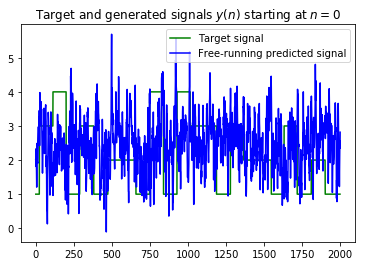

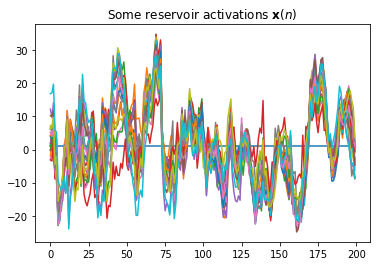

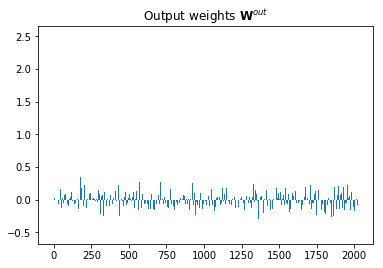

In [174]:
# compute MSE for the first errorLen time steps
errorLen = 500
ground_truth = teacher[trainLen + 1 : trainLen + errorLen + 1]
predicted = Y[:, 0:errorLen]
mse = np.mean(sum(np.square(ground_truth - predicted)))
print('MSE: {}'.format(mse))
    
# plot some signals
plt.figure(1).clear()
plt.plot(teacher[trainLen + 1 : trainLen + testLen + 1], 'g')
plt.plot(Y.T, 'b')
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])

plt.figure(2).clear()
plt.plot(X[0:20, 0:200].T)
plt.title('Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar(range(1 + inSize + resSize), Wout.T)
plt.title('Output weights $\mathbf{W}^{out}$')

plt.show()